In [264]:
import os
import pandas as pd
import numpy as np
import sys
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import seaborn as sns
import plotnine as gg
from sklearn.manifold import TSNE
from pathlib import Path
import umap.umap_ as umap


In [296]:

outpath = "/Users/habbasi/Documents/Github/broadinstitute/ProteinKinase_NathianelGray/Figures/TSNE_PCA/"

def makedirectory(path):
    try:
        if not os.path.exists(path):
            
            return os.mkdir(path)
    except OSError as e: 
        print("inside exception", e)
        sys.exit()

makedirectory(outpath)    

## Data Paths

In [297]:
path = Path("../collated/")

fname = "C-7210-01-CMP-008-gray_collapsed_sampled.csv"


## UMAP

/Users/habbasi/plotnine/plotnine/ggplot.py:729: PlotnineWarning: Saving 6.4 x 4.8 in image.
/Users/habbasi/plotnine/plotnine/ggplot.py:730: PlotnineWarning: Filename: /Users/habbasi/Documents/Github/broadinstitute/ProteinKinase_NathianelGray/Figures/test/umap_DCLK1.png
/Users/habbasi/plotnine/plotnine/ggplot.py:729: PlotnineWarning: Saving 6.4 x 4.8 in image.
/Users/habbasi/plotnine/plotnine/ggplot.py:730: PlotnineWarning: Filename: /Users/habbasi/Documents/Github/broadinstitute/ProteinKinase_NathianelGray/Figures/test/umap_PIN1.png
/Users/habbasi/plotnine/plotnine/ggplot.py:729: PlotnineWarning: Saving 6.4 x 4.8 in image.
/Users/habbasi/plotnine/plotnine/ggplot.py:730: PlotnineWarning: Filename: /Users/habbasi/Documents/Github/broadinstitute/ProteinKinase_NathianelGray/Figures/test/umap_ERK5.png
/Users/habbasi/plotnine/plotnine/ggplot.py:729: PlotnineWarning: Saving 6.4 x 4.8 in image.
/Users/habbasi/plotnine/plotnine/ggplot.py:730: PlotnineWarning: Filename: /Users/habbasi/Documents/

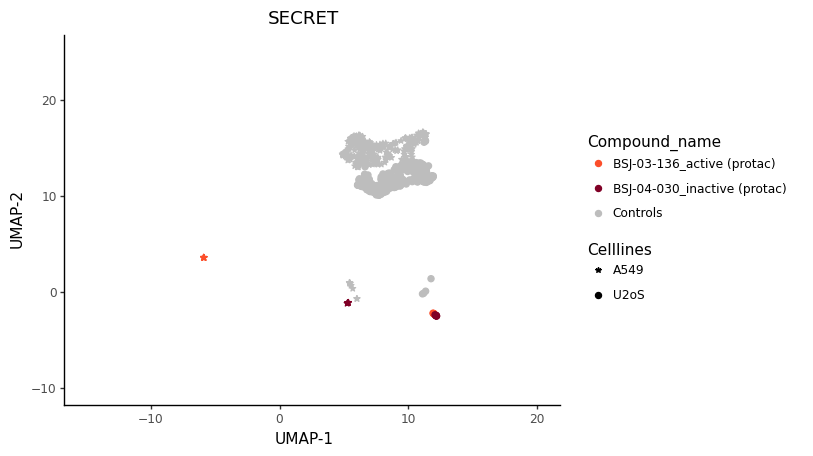

<ggplot: (7016397113)>

In [294]:
def umap_clustering(path, fname, plotting, outpath):
    """ path: path of dafa file
        fname: name of data file
        plotting: options ['all', 'individual']
        'all': include all targets
        'individual': include each target along with controls
        """
    
    fpath = os.path.join(path, fname)
    
    df = pd.read_csv(fpath)
    
    metadata = [col for col in df.columns if "Metadata" in col]
    var = [col for col in df.columns if not "Metadata" in col]
    
    
## Note some of the Costes features are not removed and have to be removed

    exclude_var = ['Cells_Correlation_Costes_DNA_Mito',
                   'Cytoplasm_Correlation_Costes_DNA_Mito',
                   'Cytoplasm_Correlation_Costes_DNA_RNA']

    variables = [v for v in var if v not in exclude_var]
    
    ## Umap fitting

    reducer=umap.UMAP(random_state=np.random.RandomState(0))
    embedding = reducer.fit_transform(df.loc[:, variables].values)


    test = pd.DataFrame(embedding, columns= ['UMAP-1', 'UMAP-2'])
    combined = test.merge(df.loc[:, metadata], left_index=True, right_index=True)
    
    ## Data Structuring
    
    combined['Metadata_Target'].replace([np.nan, 'CDK14 / pan-TAIRE'], ['Controls', 'CDK14_pan-TAIRE'], inplace=True)
    combined['Metadata_Annotation'].replace('active ', 'active', inplace=True)
    combined['Metadata_combined_name'] = combined['Metadata_compound_name'] + "_{" + combined['Metadata_Annotation'] + "}_" + combined['Metadata_Target']

    combined['Metadata_test'] = combined['Metadata_compound_name'] + "_" + combined['Metadata_Annotation']
    combined['Metadata_test'].replace(['DMSO_control', 'C4_control', 'C3_control', 'C2_control', 'C1_control'], 
                                                                       'Controls', inplace=True)
    
    if plotting == "all":
        
        
    
    
        map_colors = {'DMSO_{control}_Controls':'#bdbdbd',
                  'FMF-03-146-1_{active}_DCLK1':'#02818a',
                  'BJP-06-115-3_{inactive}_PIN1': '#fc8d59',
                  'BJP-06-005-3_{active}_PIN1': '#08519c',
                  'C4_{control}_Controls':'#bdbdbd',
                  'FMF-04-112-1_{inactive}_DCLK1': '#41b6c4',
                  'JWG-071_{active}_ERK5': '#dd3497',
                  'PND-1186_{active}_FAK':'#000000',
                  'C3_{control}_Controls':'#bdbdbd',
                  'FMF-04-159-2_{covalent}_CDK14_pan-TAIRE': '#feb24c',
                  'AX15836_{active}_ERK5':'#9ebcda',
                  'BSJ-04-030_{inactive (protac)}_SECRET': '#800026',
                  'C2_{control}_Controls':'#bdbdbd',
                  'FMF-05-176-1_{reversible}_CDK14_pan-TAIRE': '#2171b5',
                  'JWG-119_{inactive}_ERK5': '#c7e9b4',
                  'BSJ-03-136_{active (protac)}_SECRET': '#fc4e2a',
                  'C1_{control}_Controls':'#bdbdbd',
            
                 }


        g = gg.ggplot(combined, gg.aes(x='UMAP-1', y='UMAP-2', color= 'Metadata_combined_name', shape="Metadata_cell_line")) + \
        gg.geom_point(size = 2) + \
        gg.xlab("UMAP-1") + \
        gg.ylab("UMAP-2") + \
        gg.xlim(-3,15) + \
        gg.ylim(-10,25) + \
        gg.theme_classic() + \
        gg.scale_colour_manual(name= 'Compound_name', values=map_colors) + \
        gg.scale_shape_manual(name="Celllines", labels=['A549', 'U2oS'], values=['*', 'o']) + \
        gg.labs(title="UMAP")
        ggsave(filename='umap_allcompounds.png', plot = g, path=outpath)
        
    elif plotting == "individual":
        
        map_colors = {'Controls': '#bdbdbd',
              'FMF-03-146-1_active': '#02818a',
              'BJP-06-115-3_inactive': '#fc8d59',
              'BJP-06-005-3_active': '#08519c',
              'FMF-04-112-1_inactive': '#41b6c4',
              'JWG-071_active': '#dd3497',
              'PND-1186_active':'#000000',
              'FMF-04-159-2_covalent': '#feb24c',
              'AX15836_active':'#9ebcda',
              'BSJ-04-030_inactive (protac)': '#800026',
              'FMF-05-176-1_reversible': '#2171b5',
              'JWG-119_inactive': '#c7e9b4',
              'BSJ-03-136_active (protac)': '#fc4e2a'
              
              
             }

        lst = combined.Metadata_Target.unique()


        lst = list(filter(lambda x: x != "Controls", lst))

        for i in lst:

            options = ['Controls', i]
            d = combined.loc[combined['Metadata_Target'].isin(options)]

            g = gg.ggplot(d, gg.aes(x='UMAP-1', y='UMAP-2', color= 'Metadata_test', shape="Metadata_cell_line")) + \
            gg.geom_point(size = 2) + \
            gg.xlab("UMAP-1") + \
            gg.ylab("UMAP-2") + \
            gg.ggtitle(i) + \
            gg.xlim(-15,20) + \
            gg.ylim(-10,25) + \
            gg.theme_classic() + \
            gg.scale_colour_manual(name= 'Compound_name', values=map_colors) + \
            gg.scale_shape_manual(name="Celllines", labels=['A549', 'U2oS'], values=['*', 'o'])
            ggsave(filename='umap_' + i + '.png', plot = g, path=outpath)
            
            
    
    return g
    
    
        
        
## calling function
           
umap_clustering(path, fname, plotting="individual", outpath)



    
    
    
    
    
    
    
    
    
    





## T-SNE

/Users/habbasi/plotnine/plotnine/ggplot.py:729: PlotnineWarning: Saving 6.4 x 4.8 in image.
/Users/habbasi/plotnine/plotnine/ggplot.py:730: PlotnineWarning: Filename: /Users/habbasi/Documents/Github/broadinstitute/ProteinKinase_NathianelGray/Figures/TSNE_PCA/Gray_project_t-SNE.png


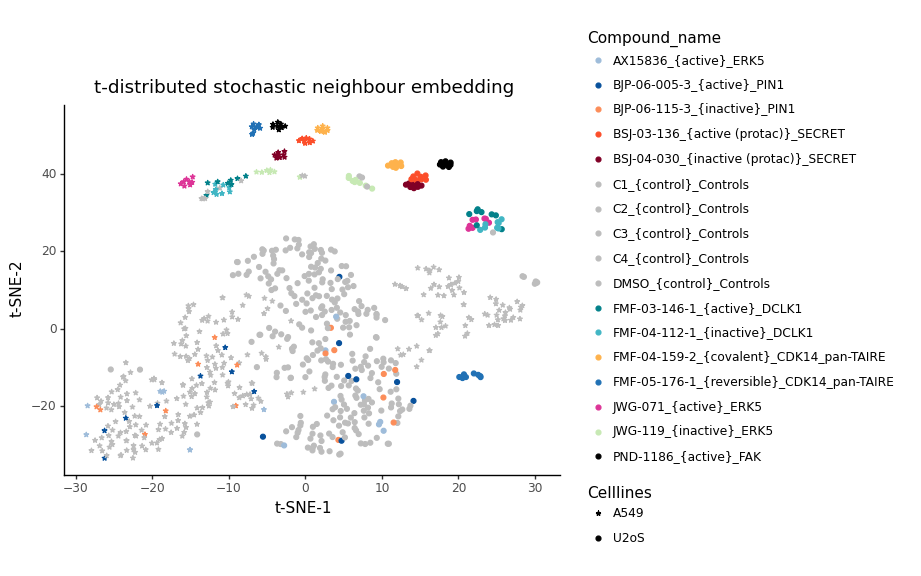

<ggplot: (7019538077)>

In [298]:


def TSNE_function(path, fname, outpath):
    
    """ path: path of dafa file
        fname: name of data file
        plotting: options ['all', 'individual']
        'all': include all targets
        'individual': include each target along with controls
        """
    
    fpath = os.path.join(path, fname)
    
    df = pd.read_csv(fpath)
    
    metadata = [col for col in df.columns if "Metadata" in col]
    var = [col for col in df.columns if not "Metadata" in col]
    
    
## Note some of the Costes features are not removed and have to be removed

    exclude_var = ['Cells_Correlation_Costes_DNA_Mito',
                   'Cytoplasm_Correlation_Costes_DNA_Mito',
                   'Cytoplasm_Correlation_Costes_DNA_RNA']

    variables = [v for v in var if v not in exclude_var]
    
    
    # Fit and transform with t-SNE


    model = TSNE(n_components=2, random_state=0, learning_rate=100, n_iter=1000, perplexity=30)


    x_2d = model.fit_transform(df.loc[:, variables].values)

    test = pd.DataFrame(x_2d, columns= ['t-SNE-1', 't-SNE-2'])

    combined = test.merge(df.loc[:, metadata], left_index=True, right_index=True)

    combined['Metadata_Target'].replace([np.nan, 'CDK14 / pan-TAIRE'], ['Controls', 'CDK14_pan-TAIRE'], inplace=True)
    combined['Metadata_Annotation'].replace('active ', 'active', inplace=True)
    combined['Metadata_combined_name'] = combined['Metadata_compound_name'] + "_{" + combined['Metadata_Annotation'] + "}_" + combined['Metadata_Target']
    combined['Metadata_test'] = combined['Metadata_compound_name'] + "_" + combined['Metadata_Annotation']
    combined['Metadata_test'].replace(['DMSO_control', 'C4_control', 'C3_control', 'C2_control', 'C1_control'], 
                                                                           'Controls', inplace=True)
    
    ## Plotting
    
    map_colors = {'DMSO_{control}_Controls':'#bdbdbd',
              'FMF-03-146-1_{active}_DCLK1':'#02818a',
              'BJP-06-115-3_{inactive}_PIN1': '#fc8d59',
              'BJP-06-005-3_{active}_PIN1': '#08519c',
              'C4_{control}_Controls':'#bdbdbd',
              'FMF-04-112-1_{inactive}_DCLK1': '#41b6c4',
              'JWG-071_{active}_ERK5': '#dd3497',
              'PND-1186_{active}_FAK':'#000000',
              'C3_{control}_Controls':'#bdbdbd',
              'FMF-04-159-2_{covalent}_CDK14_pan-TAIRE': '#feb24c',
              'AX15836_{active}_ERK5':'#9ebcda',
              'BSJ-04-030_{inactive (protac)}_SECRET': '#800026',
              'C2_{control}_Controls':'#bdbdbd',
              'FMF-05-176-1_{reversible}_CDK14_pan-TAIRE': '#2171b5',
              'JWG-119_{inactive}_ERK5': '#c7e9b4',
              'BSJ-03-136_{active (protac)}_SECRET': '#fc4e2a',
              'C1_{control}_Controls':'#bdbdbd',
            
             }




    p = gg.ggplot(combined, gg.aes(x='t-SNE-1', y='t-SNE-2', color='Metadata_combined_name', label='Metadata_compound_name', shape='Metadata_cell_line')) + \
        gg.geom_point() + \
        gg.theme_classic() + \
        gg.xlab("t-SNE-1") + \
        gg.ylab("t-SNE-2") + \
        gg.ggtitle("t-distributed stochastic neighbour embedding") + \
        gg.scale_colour_manual(name= 'Compound_name', values=map_colors) + \
        gg.scale_shape_manual(name="Celllines", labels=['A549', 'U2oS'], values=['*', 'o'])



    ggsave(filename='Gray_project_t-SNE.png', plot = p, path = outpath)

    return p

## calling a function  
    
TSNE_function(path, fname, outpath)    
    

